In [11]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import math

In [87]:
def read_data(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    nodes = []
    quantities = {}

    for request in root.findall('requests/request'):
        children = list(request)
        quantities[request.attrib['node']] = float(children[0].text)

    for node in root.findall('network/nodes/node'):
        id = node.attrib['id']
        cx = float(node[0].text)
        cy = float(node[1].text)
        quantity = 0
        if(id != '1'):
            quantity = quantities[node.attrib['id']]

        nodes.append({
            'id': id,
            'cx': cx,
            'cy': cy,
            'quantity': quantity
            })
            
    return {
        'depot': nodes[0],
        'orders': np.array(nodes[1:]),
        'num_orders': len(nodes) - 1,
        'max_capacity': float(root.findtext('fleet/vehicle_profile/capacity'))
    }

filename = 'A-n32-k05.xml'
data = read_data('../Datasets/augerat-1995-set-a/' + filename)
orders_dictionary = {}
for order in data['orders']:
    orders_dictionary[order['id']] = order

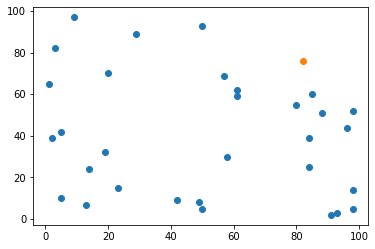

In [88]:
x = [order['cx'] for order in data['orders']]
y = [order['cy'] for order in data['orders']]

plt.scatter(x,y)
plt.scatter(data['depot']['cx'],data['depot']['cy'])
plt.show()

In [89]:
class HeuristicSolver:
    def __init__(self, depot, orders, num_orders, num_vehicles = 5, vehicle_max_capacity = 100):
        self.depot = depot
        self.orders = orders
        self.orders_left = orders
        self.num_orders = num_orders
        self.num_vehicles = num_vehicles
        self.vehicle_max_capacity = vehicle_max_capacity
    
    def generate_routes(self):
        self.routes = []
        self.total_distance = 0
        self.__calc_route(-1, 0, [], 0, 1)
        return self.routes, self.total_distance

    def __calc_route(self, cur_order_index, cur_capacity, cur_route, cur_dist, cur_vehicle):
        cur_order = None
        if cur_order_index >= 0:
            cur_order = self.orders_left[cur_order_index]

        if(cur_vehicle > self.num_vehicles):
            return

        if cur_order:
            if cur_capacity + cur_order['quantity'] > self.vehicle_max_capacity :
                if len(cur_route) > 0:
                    self.routes.append(cur_route)
                    self.total_distance += cur_dist
                self.__calc_route(-1, 0, [], 0, cur_vehicle+1)
                return
            else:
                self.orders_left = np.delete(self.orders_left, cur_order_index)

        index, dist = self.__findClosestNode(cur_order if cur_order else self.depot)
        if index == -1 :
            if len(cur_route) > 0:
                cur_dist += self.__distance(cur_order, self.depot)
                self.total_distance += cur_dist
                self.routes.append(cur_route)
            return

        if cur_order:
            cur_capacity += cur_order['quantity']
            cur_route.append(cur_order['id'])
        cur_dist += dist

        self.__calc_route(index, cur_capacity, cur_route, cur_dist, cur_vehicle)


        
    def __findClosestNode(self, cur_order):
        min_dist = float('inf')
        min_dist_index = -1; 
        for i in range(len(self.orders_left)):
            if(self.orders_left[i]['id'] == cur_order['id']):
                continue
            cur_dist = self.__distance(cur_order, self.orders_left[i])
            if(cur_dist < min_dist):
                min_dist = cur_dist
                min_dist_index = i
        return min_dist_index, min_dist
            
    def __distance(self, a, b):
        return math.sqrt((a['cx'] - b['cx'])**2 + (a['cy'] - b['cy'])**2)



In [90]:
heuristicSolver = HeuristicSolver(data['depot'], data['orders'], data['num_orders'])
routes, total_distance = heuristicSolver.generate_routes()

In [91]:
class RoutesPlotter:
    def __init__(self, depot, routes, title):
        self.routes = routes
        self.depot = depot
        self.title = title
    
    def plot(self):
        for route in self.routes:
            x = [self.depot['cx']]
            y = [self.depot['cy']]
            x.extend(list(orders_dictionary[id]['cx'] for id in route))
            y.extend(list(orders_dictionary[id]['cy'] for id in route))
            x.append(self.depot['cx'])
            y.append(self.depot['cy'])
            plt.plot(x, y)
            plt.scatter(x, y)
        plt.scatter(self.depot['cx'],self.depot['cy'])
        plt.title(self.title)
        plt.show()

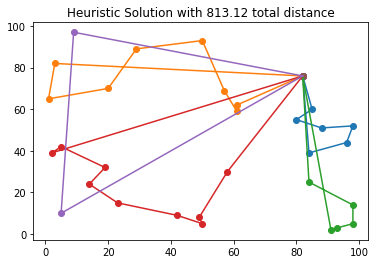

In [92]:
plotter = RoutesPlotter(data['depot'], routes, 'Heuristic Solution with ' + str(round(total_distance, 2)) + ' total distance').plot()